# Multitask Models

Testa modelos de multitasking

## Configuração de Ambiente

In [1]:
# Variáveis de Configuração

# Caminhos de arquivo
raw_data_path = '../data/raw-data/'                 # dados não processados
raw_dataset_path = raw_data_path + 'train_updated.csv'
processed_data_path = '../data/processed-data/'     # dados processados
processed_dataset_path = processed_data_path + 'train.pkl' 
model_path = '../models/trained-models/'

In [30]:
# Imports

# Data manipulation
import pandas as pd
import numpy as np

import pickle as pkl

from joblib import Parallel, delayed

from matplotlib import pyplot as plt

from models import *

# disable warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [3]:
# Variáveis/Constantes Globais
TARGET_COLS = ['target1', 'target2', 'target3', 'target4']

RANDOM_SEED = 42

TEST_SPLIT_DATE = '2021-04-30'

In [4]:
# Carregando o dataframe
df_train = pd.read_pickle(processed_dataset_path)
df_train.head()

,Dt,IdPlayer,target1,target2,target3,target4,IdDtPlayer,target1_shift_1,target2_shift_1,target3_shift_1,...,CdGameState_Final,CdDoubleHeader_N,CdDoubleHeader_S,CdDoubleHeader_Y,CdDayNight_day,CdDayNight_night,FlgWinnerHomeTeam_False,FlgWinnerHomeTeam_True,FlgWinnerAwayTeam_False,FlgWinnerAwayTeam_True
0,2018-01-08,112526,0.032349,4.394531,0.039185,17.625000,2018-01-08 00:00:00_112526,0.014557,4.714844,0.026337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-09,112526,0.016098,1.791016,0.055420,4.628906,2018-01-09 00:00:00_112526,0.032349,4.394531,0.039185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-10,112526,0.075623,1.867188,0.023239,8.507812,2018-01-10 00:00:00_112526,0.016098,1.791016,0.055420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-11,112526,0.035004,2.285156,0.020096,7.941406,2018-01-11 00:00:00_112526,0.075623,1.867188,0.023239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-12,112526,0.018204,0.624023,0.007935,4.925781,2018-01-12 00:00:00_112526,0.035004,2.285156,0.020096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preparação dos Dados

Manter no notebook apenas a preparação pontual dos dados para a aplicação em modelos, toda preparação permanente deve ser adicionada em `/src/data-engineering/data-engineering.ipynb` e então salvo o dataset processado em `/src/data/processed-data/`.

### Funções Auxiliares

Apenas manter aqui funções que serão utilizadas pontualmente no notebook, em caso de funções que serão usadas em outros notebooks, deve-se transferir as mesmas para um arquivo `.py` separado e importar as funções para o notebook.

In [5]:
# Funções Auxiliares

# Imports
from data_preparation import *

# Funções Auxiliares


### Preparação

In [6]:
#Arruma float16 para conseguir rodar baselines
df_train[TARGET_COLS] = df_train[TARGET_COLS].astype('float', copy = True)

In [7]:
df_train = df_train.drop([col for col in df_train.columns if df_train[col].dtype == 'object'], axis=1)
df_train = df_train.drop(['DtGame','IdTeam_x', 'IdTeam_y', 'IdGame'], axis=1)

### Train Test Split

In [8]:
train, test, val = train_test_split(df_train)

In [9]:
train['Dt'] = pd.to_numeric(pd.to_datetime(train['Dt']))
test['Dt']= pd.to_numeric(pd.to_datetime(test['Dt']))
val['Dt'] = pd.to_numeric(pd.to_datetime(val['Dt']))

## Treinando Modelos

In [10]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.multioutput import MultiOutputRegressor

df_results = pd.DataFrame(columns = ['model', 'target1', 'target2', 'target3', 'target4', 'average'])
df_results_amae = pd.DataFrame(columns = ['model', 'target1', 'target2', 'target3', 'target4', 'average'])

### Baselines

In [11]:
# naive
naive = train[train['Dt']=='2021-04-30'].set_index('IdPlayer')[TARGET_COLS]

# media
media = train[TARGET_COLS].mean()
media_por_jogador = train.groupby('IdPlayer')[TARGET_COLS].mean()

# mediana
mediana = train[TARGET_COLS].median()
mediana_por_jogador = train.groupby('IdPlayer')[TARGET_COLS].median()

In [12]:
%%time
summary = pd.DataFrame()

for target in TARGET_COLS:
    
    y_true = test[target]
   
    mediapj_pred = test['IdPlayer'].map(media_por_jogador[target].to_dict())
    medianapj_pred = test['IdPlayer'].map(mediana_por_jogador[target].to_dict())
    naive_pred = test['IdPlayer'].map(naive[target].to_dict())
  
    mediana_pred = [mediana[target] for i in test.index]
    media_pred = [media[target] for i in test.index]
    

    summary.loc['Média',target]  = mean_absolute_error(y_true,media_pred)
    summary.loc['Média por Jogador',target]  = mean_absolute_error(y_true,mediapj_pred)
    summary.loc['Mediana',target]  = mean_absolute_error(y_true,mediana_pred)
    summary.loc['Mediana por Jogador',target]  = mean_absolute_error(y_true,medianapj_pred)
    #summary.loc['Naive',target]  = mean_absolute_error(y_true,naive_pred)
    
summary['average'] = summary.mean(axis=1)
summary = summary.reset_index()
summary = summary.rename(columns = {"index": "model"})
df_results = df_results.append(summary, ignore_index = True)
df_results

CPU times: total: 2.3 s
Wall time: 5.08 s


,model,target1,target2,target3,target4,average
0,Média,1.154659,2.733154,1.081328,1.458545,1.606922
1,Média por Jogador,0.975862,2.281572,0.974669,1.033312,1.316354
2,Mediana,0.744365,1.667283,0.512541,1.149322,1.018378
3,Mediana por Jogador,0.734746,1.601819,0.508404,0.936245,0.945304


In [13]:
%%time
summary = pd.DataFrame()
for target in TARGET_COLS:
    
    y_true = test[target]
    
    mediapj_pred = test['IdPlayer'].map(media_por_jogador[target].to_dict())
    medianapj_pred = test['IdPlayer'].map(mediana_por_jogador[target].to_dict())
    naive_pred = test['IdPlayer'].map(naive[target].to_dict())
    
    mediana_pred = [mediana[target] for i in test.index]
    media_pred = [media[target] for i in test.index]
    
    
    summary.loc['Média',target]  =  AMAE(y_true,media_pred,show = False)
    summary.loc['Média por Jogador',target]  =  AMAE(y_true,mediapj_pred,show = False)
    summary.loc['Mediana',target]  =  AMAE(y_true,mediana_pred,show = False)
    summary.loc['Mediana por Jogador',target]  =  AMAE(y_true,medianapj_pred,show = False)
    #summary.loc['Naive',target]  =  AMAE(y_true,naive_pred,show = False)
    
summary['average'] = summary.mean(axis=1)
summary = summary.reset_index()
summary = summary.rename(columns = {"index": "model"})

CPU times: total: 1min 15s
Wall time: 1min 58s


In [14]:
df_results_amae = df_results_amae.append(summary, ignore_index = True)
df_results_amae

,model,target1,target2,target3,target4,average
0,Média,6843.978819,6398.583724,7121.952787,6823.816072,6797.082850
1,Média por Jogador,6414.161377,5524.151229,6761.462720,6119.308259,6204.770897
2,Mediana,6900.775560,6587.051921,7190.445719,6912.163273,6897.609118
3,Mediana por Jogador,6833.931392,6005.371015,7149.410960,6419.212379,6601.981437


### Modelos Lineares

#### LASSO

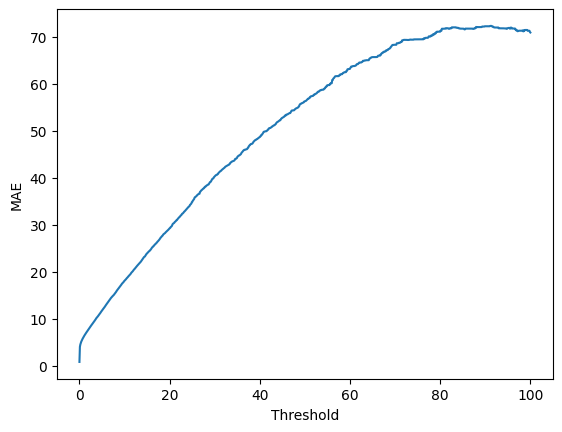

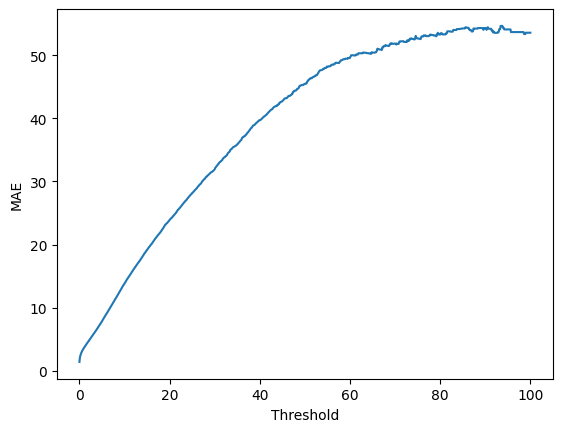

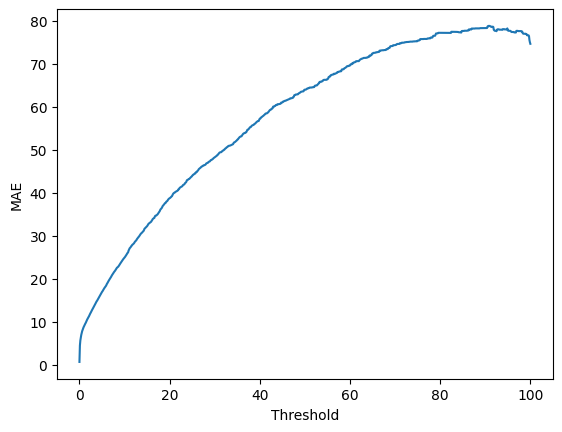

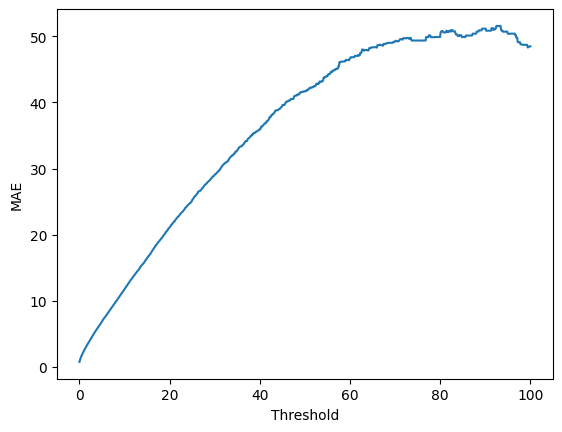

CPU times: total: 38min 3s
Wall time: 14min 58s


,model,target1,target2,target3,target4,average
4,Lasso | MultiOutput,0.814124,1.379381,0.726231,0.752602,0.918085
5,Lasso | MultiOutput,5062.777610,3933.843342,5762.569930,3632.583671,4597.943638


In [15]:
%%time
from sklearn.linear_model import Lasso

# defines the model and create the multioutput regressor
model = Lasso(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'Lasso | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)

# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)

# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]

df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

#### Ridge

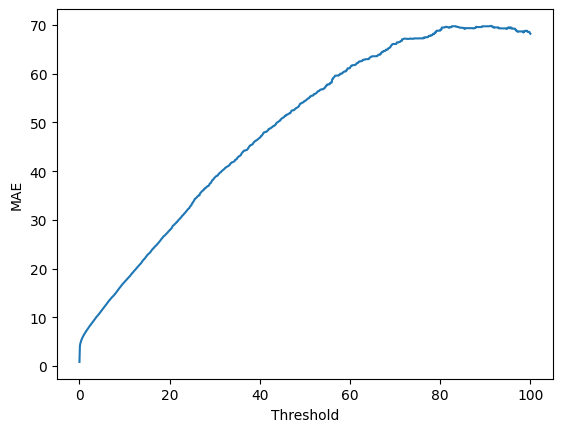

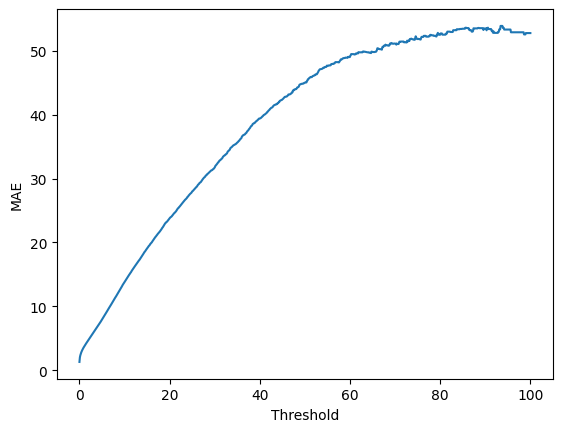

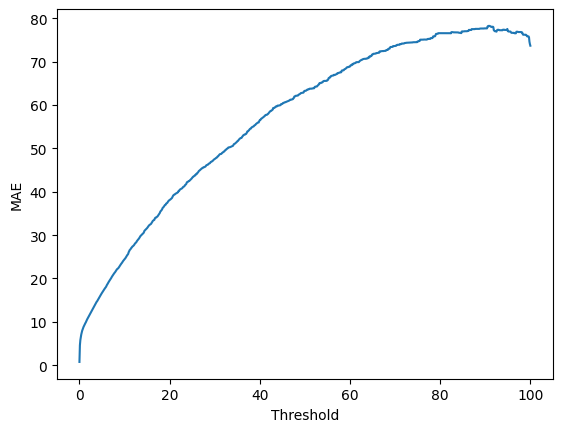

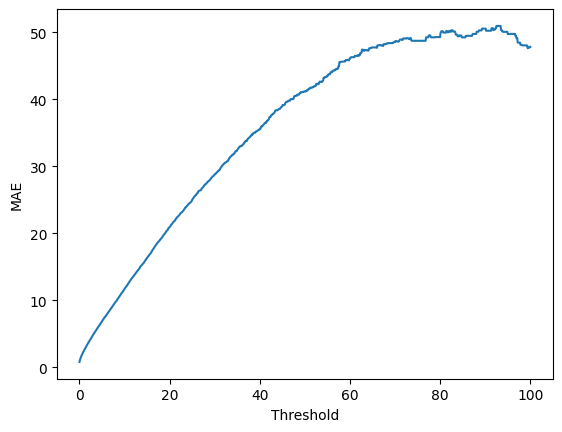

CPU times: total: 57.2 s
Wall time: 38.6 s


,model,target1,target2,target3,target4,average
5,Ridge | MultiOutput,0.825701,1.288335,0.756863,0.777672,0.912143
6,Ridge | MultiOutput,4887.688917,3889.218251,5695.880423,3590.584840,4515.843108


In [16]:
%%time
from sklearn.linear_model import Ridge

# defines the model and create the multioutput regressor
model = Ridge(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'Ridge | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)

# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

#### ElasticNet

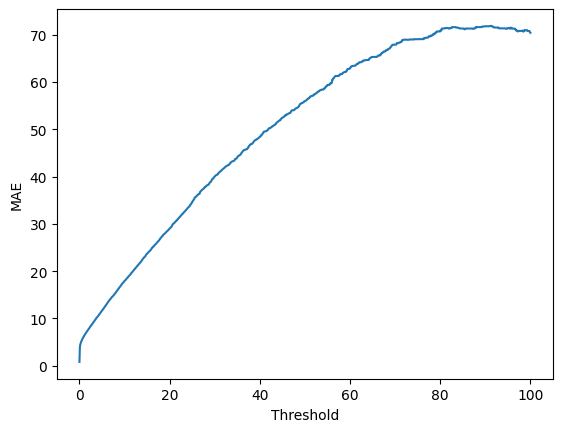

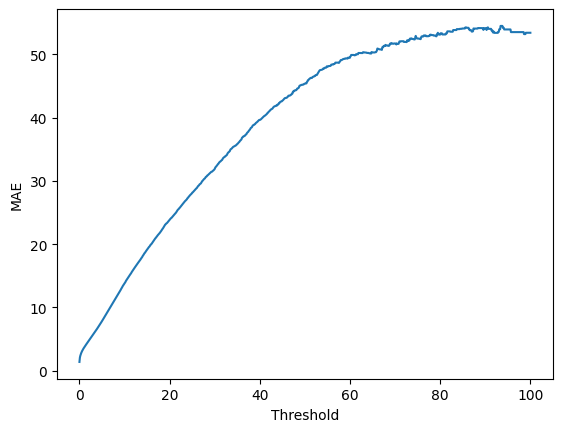

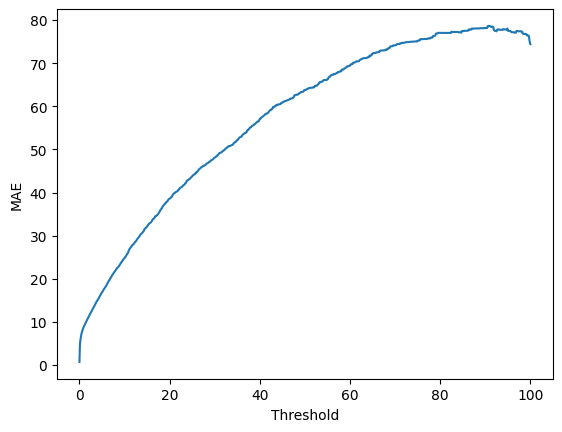

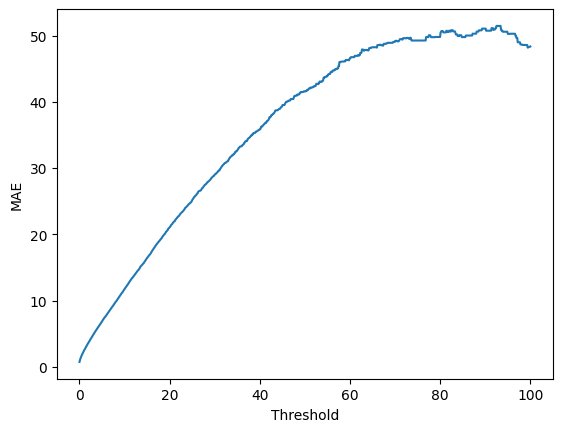

CPU times: total: 1h 50min 45s
Wall time: 40min 8s


,model,target1,target2,target3,target4,average
6,ElasticNet | MultiOutput,0.816179,1.369645,0.727134,0.754380,0.916834
7,ElasticNet | MultiOutput,5030.555538,3924.813972,5742.385928,3624.635428,4580.597717


In [17]:
%%time
from sklearn.linear_model import ElasticNet

# defines the model and create the multioutput regressor
model = ElasticNet(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'ElasticNet | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

### Tree Models

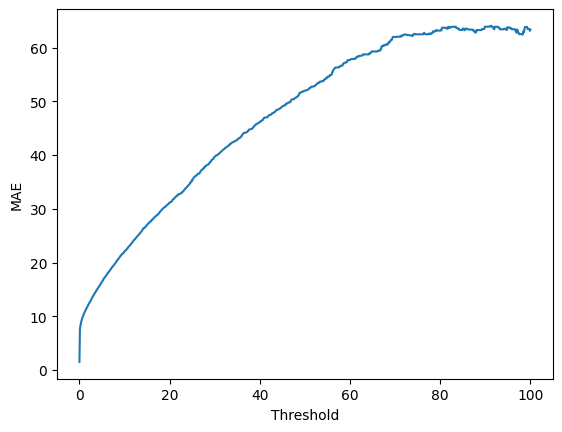

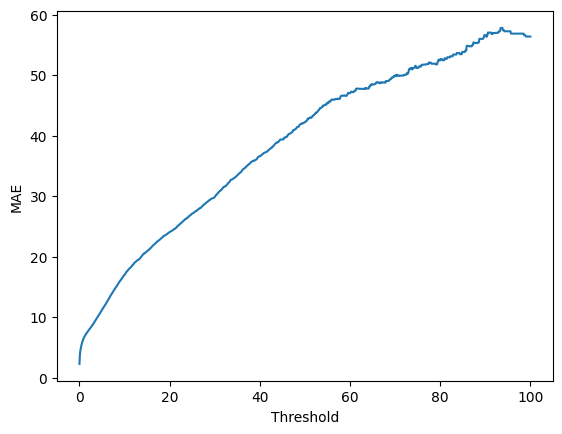

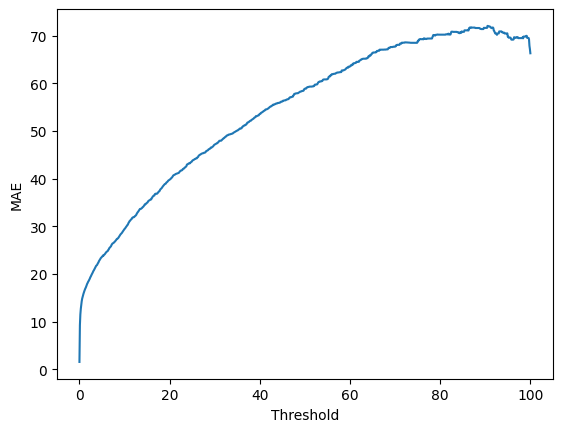

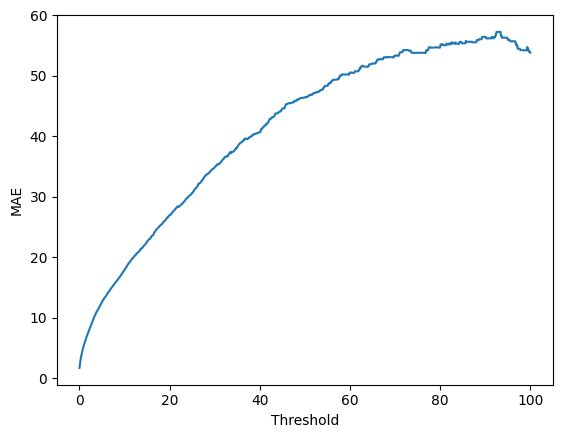

CPU times: total: 16min 31s
Wall time: 2h 31min 58s


,model,target1,target2,target3,target4,average
7,DecisionTreeRegressor | MultiOutput,1.502517,2.306391,1.578806,1.733201,1.780229
8,DecisionTreeRegressor | MultiOutput,4740.343999,3883.428789,5450.884571,4139.395303,4553.513165


In [18]:
%%time
from sklearn.tree import DecisionTreeRegressor

# defines the model and create the multioutput regressor
model = DecisionTreeRegressor(random_state=RANDOM_SEED)
model_name = 'DecisionTreeRegressor | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

#### Gradient Boosting

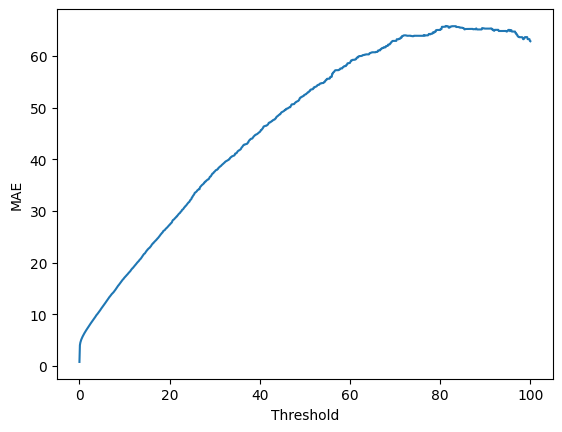

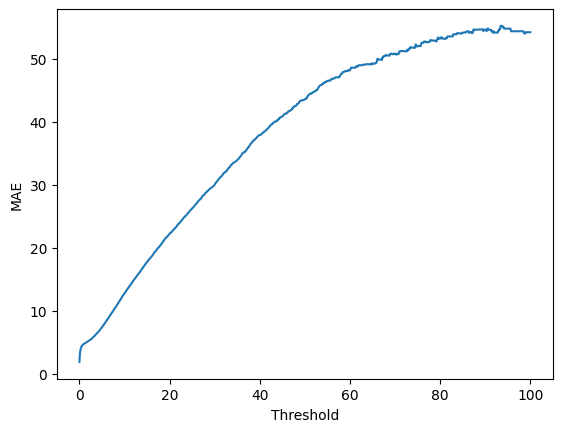

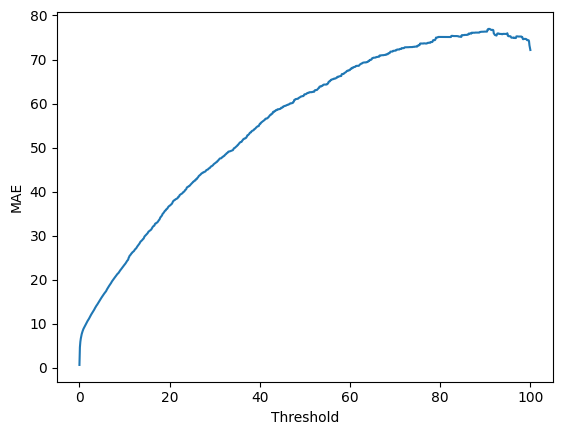

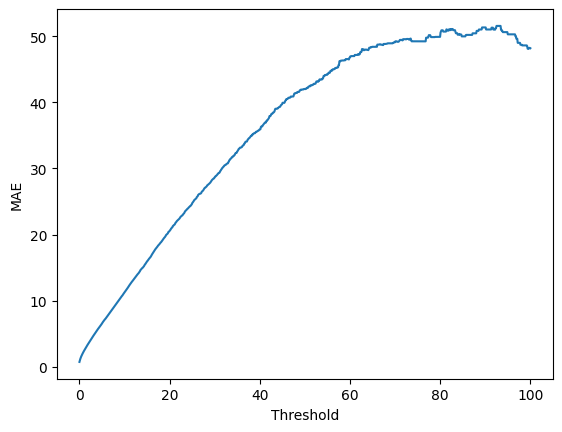

CPU times: total: 2h 38min 4s
Wall time: 3h 9min 10s


,model,target1,target2,target3,target4,average
8,GradientBoostingRegressor | MultiOutput,0.752180,1.917165,0.684236,0.733078,1.021665
9,GradientBoostingRegressor | MultiOutput,4672.895955,3832.671327,5572.403957,3623.021489,4425.248182


In [19]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

# defines the model and create the multioutput regressor
model = GradientBoostingRegressor(random_state=RANDOM_SEED)
model_name = 'GradientBoostingRegressor | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

## Resultados

In [20]:
df_results

,model,target1,target2,target3,target4,average
0,Média,1.154659,2.733154,1.081328,1.458545,1.606922
1,Média por Jogador,0.975862,2.281572,0.974669,1.033312,1.316354
2,Mediana,0.744365,1.667283,0.512541,1.149322,1.018378
3,Mediana por Jogador,0.734746,1.601819,0.508404,0.936245,0.945304
4,Lasso | MultiOutput,0.814124,1.379381,0.726231,0.752602,0.918085
5,Ridge | MultiOutput,0.825701,1.288335,0.756863,0.777672,0.912143
6,ElasticNet | MultiOutput,0.816179,1.369645,0.727134,0.754380,0.916834
7,DecisionTreeRegressor | MultiOutput,1.502517,2.306391,1.578806,1.733201,1.780229
8,GradientBoostingRegressor | MultiOutput,0.752180,1.917165,0.684236,0.733078,1.021665


In [23]:
df_results_amae

,model,target1,target2,target3,target4,average
0,Média,1.154659,2.733154,1.081328,1.458545,1.606922
1,Média por Jogador,0.975862,2.281572,0.974669,1.033312,1.316354
2,Mediana,0.744365,1.667283,0.512541,1.149322,1.018378
3,Mediana por Jogador,0.734746,1.601819,0.508404,0.936245,0.945304
4,Lasso | MultiOutput,0.814124,1.379381,0.726231,0.752602,0.918085
5,Ridge | MultiOutput,0.825701,1.288335,0.756863,0.777672,0.912143
6,ElasticNet | MultiOutput,0.816179,1.369645,0.727134,0.754380,0.916834
7,DecisionTreeRegressor | MultiOutput,1.502517,2.306391,1.578806,1.733201,1.780229
8,GradientBoostingRegressor | MultiOutput,0.752180,1.917165,0.684236,0.733078,1.021665
9,GradientBoostingRegressor | MultiOutput,4672.895955,3832.671327,5572.403957,3623.021489,4425.248182


In [28]:
regressor.estimators_[0].feature_importances_

array([3.18819576e-03, 1.30642631e-04, 7.14720532e-01, 5.20382069e-02,
       6.52462709e-03, 6.40364951e-02, 5.09166256e-03, 2.68921870e-03,
       7.99988139e-04, 5.52433414e-03, 5.44427878e-03, 1.18022146e-04,
       1.72384538e-03, 4.61290694e-04, 5.48969276e-03, 0.00000000e+00,
       5.11728606e-04, 8.02445317e-05, 9.80024900e-03, 1.36945755e-03,
       1.52821593e-03, 0.00000000e+00, 1.40112663e-03, 1.28998363e-03,
       1.65346236e-04, 2.05463701e-04, 1.96592684e-03, 8.04080931e-05,
       7.61755690e-04, 9.27414314e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.36831725e-04, 4.66729295e-03, 1.73011367e-04,
       1.19935019e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.86407910e-02, 3.83600653e-05, 0.00000000e+00, 0.00000000e+00,
       6.82491404e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.32487822e-04, 0.00000000e+00, 0.00000000e+00, 1.69773207e-03,
      

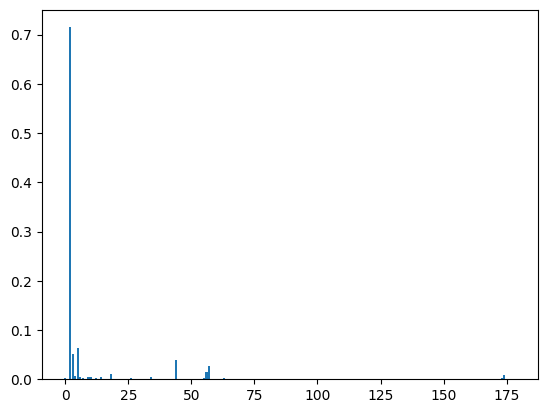

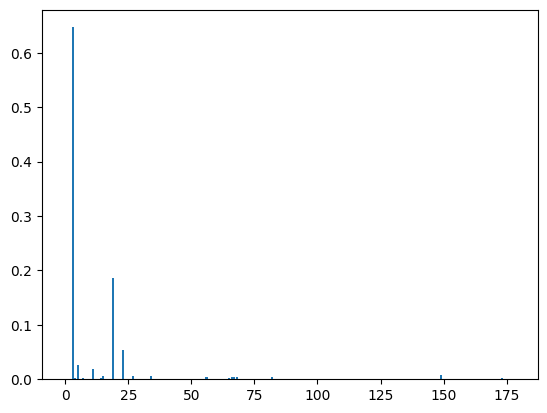

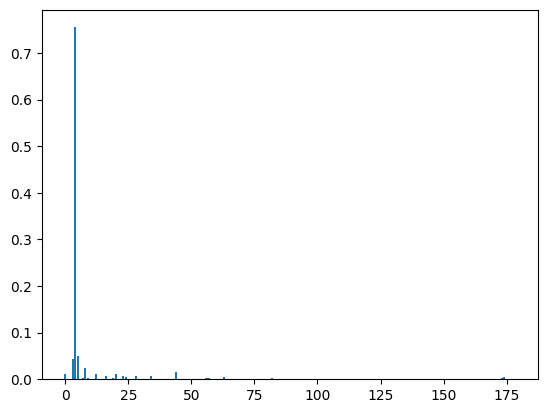

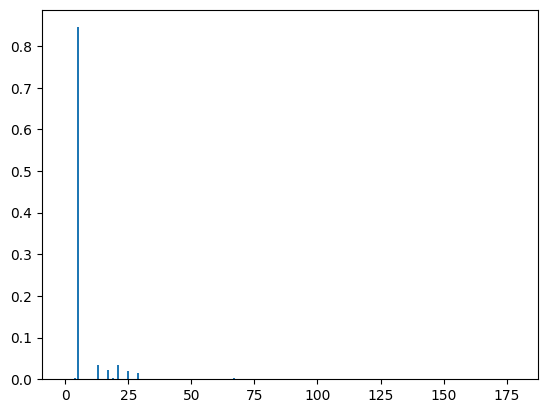

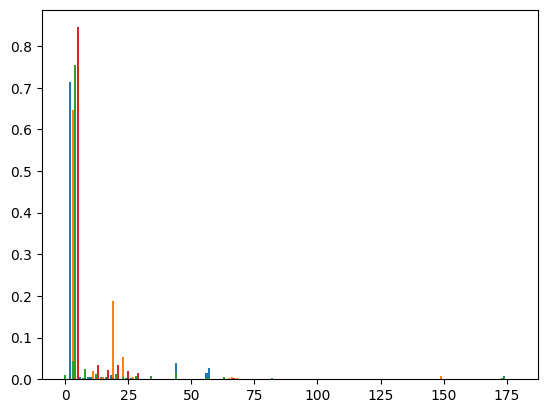

In [34]:
for i in range(len(TARGET_COLS)):
    plt.bar(range(len(regressor.estimators_[i].feature_importances_)), regressor.estimators_[i].feature_importances_)
    plt.show()
for i in range(len(TARGET_COLS)):
    plt.bar(range(len(regressor.estimators_[i].feature_importances_)), regressor.estimators_[i].feature_importances_)


In [92]:
selected_features = {}
for i in range(len(TARGET_COLS)):
    features = np.where(regressor.estimators_[i].feature_importances_ >= 0.001)
    print(train.drop(columns=TARGET_COLS).columns[features])
    # selected_features.extend(list(np.where(regressor.estimators_[i].feature_importances_ > 0.0001)))
# np.where(regressor.estimators_[0].feature_importances_ > 0.0)



Index(['Dt', 'target1_shift_1', 'target2_shift_1', 'target3_shift_1',
       'target4_shift_1', 'target1_shift_2', 'target2_shift_2',
       'target4_shift_2', 'target1_shift_3', 'target3_shift_3',
       'target1_shift_4', 'target1_shift_5', 'target2_shift_5',
       'target3_shift_5', 'target1_shift_6', 'target2_shift_6',
       'target1_shift_7', 'DtDayOfYear', 'NuStrikeOutsPitching',
       'NuHomeRuns_Player', 'NuPlateAppearances_Player', 'NuTotalBases_Player',
       'NuRbi_Player', 'NuInningsPitched_Player', 'DtHour',
       'NuEarnedRuns_Team', 'NuRbiPitching_Team', 'CdDayNight_day',
       'CdDayNight_night'],
      dtype='object')
Index(['target2_shift_1', 'target3_shift_1', 'target4_shift_1',
       'target2_shift_2', 'target2_shift_3', 'target1_shift_4',
       'target2_shift_4', 'target2_shift_5', 'target2_shift_6',
       'target2_shift_7', 'DtDayOfWeek', 'DtDayOfYear', 'NuTotalBases_Player',
       'NuEarnedRuns_Player', 'NuBattersFaced_Player',
       'NuPitchesThrown_P